 1 — Installations (si besoin) et imports

In [18]:
#  décommente pour installer
! pip install pandas numpy scikit-learn matplotlib seaborn nltk --quiet

# On importe les librairies utiles
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#  pour plus tard 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

#on télécharge la ressource NLTK
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)

# Style des graphiques et options d'affichage
sns.set(style="whitegrid")
pd.set_option('display.max_colwidth', 120)


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


2 — Charger les données

In [19]:
# importer les donner 
csv_path = "bbc-text.csv"
df = pd.read_csv(csv_path)

#On ajoute une colonne avec la longueur du texte (pour un aperçu simple)
df['text_len'] = df['text'].str.len()

df

,category,text,text_len
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders...,4333
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) ...,1842
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the ...,1342
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeadi...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve the crime caper sequel starring george clooney brad pitt and julia ...,1579
...,...,...,...
2220,business,cars pull down us retail figures us retail sales fell 0.3% in january the biggest monthly decline since last august...,1745
2221,politics,kilroy unveils immigration policy ex-chatshow host robert kilroy-silk has attacked uk policy on immigration saying b...,955
2222,entertainment,rem announce new glasgow concert us band rem have announced plans to perform for 10 000 scottish fans in a reschedul...,1648
2223,politics,how political squabbles snowball it s become commonplace to argue that blair and brown are like squabbling school ki...,4684


In [20]:
# Statistiques simples sur la longueur des textes
df.describe()

,text_len
count,2225.00000
mean,2262.93618
std,1364.10253
min,501.00000
25%,1446.00000
50%,1965.00000
75%,2802.00000
max,25483.00000


In [21]:
# Informations sur le DataFrame (types, colonnes, non-nuls)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
 2   text_len  2225 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 52.3+ KB


In [22]:
# Vérifier les valeurs manquantes
df.isnull().sum()

# Donc pas de valeurs manquantes

category    0
text        0
text_len    0
dtype: int64

3 — Nettoyage simple du texte

In [23]:
# On récupère la liste des stopwords anglais (sera utile si on souhaite les enlever plus tard)
EN_STOPWORDS = set(stopwords.words('english'))

# Fonction de nettoyage simple: minuscules, enlever liens/chiffres/ponctuation, normaliser espaces
def clean_text(s):
    if pd.isna(s):
        return ""
    s = s.lower() # tout en minuscules
    s = re.sub(r'http\S+|www\.\S+', ' ', s)   # enlever les liens
    s = re.sub(r'\d+', ' ', s)                # enlever leschiffres
    s = re.sub(r'[^a-z\s]', ' ', s)           # enlever les ponctuation
    s = re.sub(r'\s+', ' ', s).strip()        # enlever les espaces
    return s

# On crée une nouvelle colonne nettoyée
df['text_clean'] = df['text'].apply(clean_text)
df

,category,text,text_len,text_clean
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders...,4333,tv future in the hands of viewers with home theatre systems plasma high definition tvs and digital video recorders m...
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) ...,1842,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an bn bn fraud never ...
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the ...,1342,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the gr...
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeadi...,2176,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeadi...
4,entertainment,ocean s twelve raids box office ocean s twelve the crime caper sequel starring george clooney brad pitt and julia ...,1579,ocean s twelve raids box office ocean s twelve the crime caper sequel starring george clooney brad pitt and julia ro...
...,...,...,...,...
2220,business,cars pull down us retail figures us retail sales fell 0.3% in january the biggest monthly decline since last august...,1745,cars pull down us retail figures us retail sales fell in january the biggest monthly decline since last august drive...
2221,politics,kilroy unveils immigration policy ex-chatshow host robert kilroy-silk has attacked uk policy on immigration saying b...,955,kilroy unveils immigration policy ex chatshow host robert kilroy silk has attacked uk policy on immigration saying b...
2222,entertainment,rem announce new glasgow concert us band rem have announced plans to perform for 10 000 scottish fans in a reschedul...,1648,rem announce new glasgow concert us band rem have announced plans to perform for scottish fans in a rescheduled gig ...
2223,politics,how political squabbles snowball it s become commonplace to argue that blair and brown are like squabbling school ki...,4684,how political squabbles snowball it s become commonplace to argue that blair and brown are like squabbling school ki...


4 — Visualisation: distribution des catégories

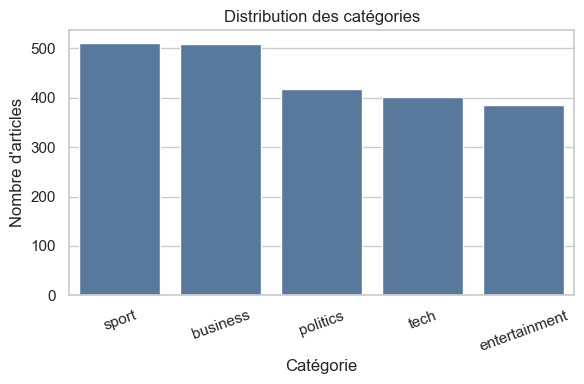

In [24]:
# Un graphique simple: combien d’articles par catégorie

plt.figure(figsize=(6,4))
order = df['category'].value_counts().index
sns.countplot(data=df, x='category', order=order, color="#4C78A8")
plt.title("Distribution des catégories")
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

 Sauvegarder le graphique en PNG 

In [25]:
plt.figure(figsize=(6,4))
order = df['category'].value_counts().index
sns.countplot(data=df, x='category', order=order, color="#4C78A8")
plt.title("Distribution des catégories")
plt.xlabel("Catégorie")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("distribution_categories.png", dpi=150)
plt.close()

 5 — Préparer les données pour la Classification

In [26]:
# préparation )
X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'], df['category'],
    test_size=0.2, random_state=42, stratify=df['category']
)

# Vectoriseur TF-IDF (1-2 mots, enlève stopwords anglais)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words='english')

# Exemples de pipelines (entraînement)
pipeline_svm = Pipeline([
    ('tfidf', tfidf),
    ('model', LinearSVC())
])

pipeline_nb = Pipeline([
    ('tfidf', tfidf),
    ('model', MultinomialNB())
])

df

,category,text,text_len,text_clean
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders...,4333,tv future in the hands of viewers with home theatre systems plasma high definition tvs and digital video recorders m...
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) ...,1842,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an bn bn fraud never ...
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the ...,1342,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the gr...
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeadi...,2176,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeadi...
4,entertainment,ocean s twelve raids box office ocean s twelve the crime caper sequel starring george clooney brad pitt and julia ...,1579,ocean s twelve raids box office ocean s twelve the crime caper sequel starring george clooney brad pitt and julia ro...
...,...,...,...,...
2220,business,cars pull down us retail figures us retail sales fell 0.3% in january the biggest monthly decline since last august...,1745,cars pull down us retail figures us retail sales fell in january the biggest monthly decline since last august drive...
2221,politics,kilroy unveils immigration policy ex-chatshow host robert kilroy-silk has attacked uk policy on immigration saying b...,955,kilroy unveils immigration policy ex chatshow host robert kilroy silk has attacked uk policy on immigration saying b...
2222,entertainment,rem announce new glasgow concert us band rem have announced plans to perform for 10 000 scottish fans in a reschedul...,1648,rem announce new glasgow concert us band rem have announced plans to perform for scottish fans in a rescheduled gig ...
2223,politics,how political squabbles snowball it s become commonplace to argue that blair and brown are like squabbling school ki...,4684,how political squabbles snowball it s become commonplace to argue that blair and brown are like squabbling school ki...


 Entraînement des 3 modèles de base


In [27]:

#  Évaluation de 3 modèles 

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import pandas as pd

# Vérifions que X_train, X_test, y_train, y_test existent déjà
print(f"X_train: {len(X_train)}, X_test: {len(X_test)}")

# Création des pipelines de base pour comparer 3 modèles

 #TF-IDF pour la vectorisation (5000 mots max, pour éviter le surapprentissage)

models = {
    "Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('model', MultinomialNB())
    ]),
    "Linear SVC": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('model', LinearSVC())
    ]),
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
        ('model', LogisticRegression(max_iter=1000))
    ])
}


X_train: 1780, X_test: 445


Ces trois modèles ont été choisis car ils sont particulièrement adaptés à la classification de texte après vectorisation TF‑IDF :

Naive Bayes : c’est un modèle de base très utilisé en traitement du langage naturel. Il est rapide, simple à entraîner et souvent performant sur les textes, surtout lorsque les mots sont considérés comme indépendants.

Linear SVC (Support Vector Classifier) : ce modèle est efficace pour les données de grande dimension, comme les représentations TF‑IDF. Il offre une grande précision et une bonne capacité de généralisation.

Régression Logistique : c’est un modèle linéaire interprétable qui fournit des probabilités de prédiction et permet d’identifier les mots les plus importants pour chaque classe.

et donc, ces trois modèles couvrent un bon équilibre entre simplicité, performance et interprétabilité, ce qui permet de comparer plusieurs approches efficaces pour la classification de texte

évaluation initiale

In [28]:
results = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'F1-Score': f1_score(y_test, preds, average='weighted'),
        'Precision': precision_score(y_test, preds, average='weighted'),
        'Recall': recall_score(y_test, preds, average='weighted')
    }
    
    print(f"\n {name}")
    print(classification_report(y_test, preds))

pd.DataFrame(results).T


 Naive Bayes
               precision    recall  f1-score   support

     business       0.97      0.96      0.97       102
entertainment       0.99      0.99      0.99        77
     politics       0.97      0.99      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.99      0.97      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445


 Linear SVC
               precision    recall  f1-score   support

     business       0.97      0.98      0.98       102
entertainment       0.97      0.99      0.98        77
     politics       0.98      0.99      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.99      0.95      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.9

,Accuracy,F1-Score,Precision,Recall
Naive Bayes,0.982022,0.982015,0.982084,0.982022
Linear SVC,0.982022,0.981984,0.982111,0.982022
Logistic Regression,0.982022,0.981984,0.982111,0.982022


In [29]:
# Vérification juste pour logistic regression
pipe_lr = models["Logistic Regression"]
pipe_lr.fit(X_train, y_train)
preds_lr = pipe_lr.predict(X_test)

print(classification_report(y_test, preds_lr))

               precision    recall  f1-score   support

     business       0.97      0.98      0.98       102
entertainment       0.97      0.99      0.98        77
     politics       0.98      0.99      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.99      0.95      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



- Naive Bayes
Offre de très bons résultats globaux (98 %).
Gère efficacement les textes courts, mais a une légère baisse sur certaines classes comme business ou tech.
Modèle rapide mais un peu moins précis que les deux suivants.

 - Linear SVC
Très performant et constant avec un F1‑score moyen de 0.98.
Prédit parfaitement certaines classes comme sport (F1 = 1.00), mais reste légèrement inférieur à la régression logistique sur la performance globale.

 - Régression Logistique
C’est le meilleur modèle sur l’ensemble de test, avec une Accuracy et un F1‑Score de 0.9820.
Montre un excellent équilibre entre toutes les classes (business, entertainment, politics, sport, tech).
Modèle à la fois précis, stable et interprétable, ce qui le rend idéal pour être conservé.


Optimisation fine des hyperparamètres, Linear SVC et Logistic Regression

In [30]:
from sklearn.model_selection import GridSearchCV

#  Optimisation du modèle Linear SVC
params_svc = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.9, 1.0],
    'model__C': [0.5, 1, 2]
}

grid_svc = GridSearchCV(
    Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', LinearSVC())
    ]),
    param_grid=params_svc,
    cv=3, n_jobs=-1, verbose=1
)
grid_svc.fit(X_train, y_train)
print(" Meilleurs paramètres Linear SVC :", grid_svc.best_params_)

#  Optimisation du modèle Logistic Regression
params_lr = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.9, 1.0],
    'model__C': [0.5, 1.0, 2]
}

grid_lr = GridSearchCV(
    Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    param_grid=params_lr,
    cv=3, n_jobs=-1, verbose=1
)
grid_lr.fit(X_train, y_train)
print(" Meilleurs paramètres Logistic Regression :", grid_lr.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Meilleurs paramètres Linear SVC : {'model__C': 0.5, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 2)}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
 Meilleurs paramètres Logistic Regression : {'model__C': 2, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 2)}


Comparaison des modèles optimisés

In [31]:
best_models = {
    "Best SVC": grid_svc.best_estimator_,
    "Best Logistic Regression": grid_lr.best_estimator_
}

compar_perf = {}
for name, model in best_models.items():
    preds = model.predict(X_test)
    compar_perf[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'F1-Score': f1_score(y_test, preds, average='weighted')
    }

pd.DataFrame(compar_perf).T

,Accuracy,F1-Score
Best SVC,0.979775,0.979743
Best Logistic Regression,0.986517,0.986504


 Après ajustement des hyperparamètres (C, max_df, ngram_range), la Régression Logistique optimisée affiche une progression significative du F1‑Score (+0.004), atteignant 98.65 %.
Le Linear SVC, en revanche, reste stable mais n’améliore pas ses performances après optimisation, ce qui confirme qu’il était déjà à son plein potentiel.
Cela prouve que la tuning de la régularisation (C=2) pour la Régression Logistique rend le modèle plus flexible, sans perte de généralisation.

Visualisation des résultats comparatifs

C:\Users\GB Tech\AppData\Local\Temp\ipykernel_67820\3779489950.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_df, x='Modèle', y='F1-Score', palette='viridis')


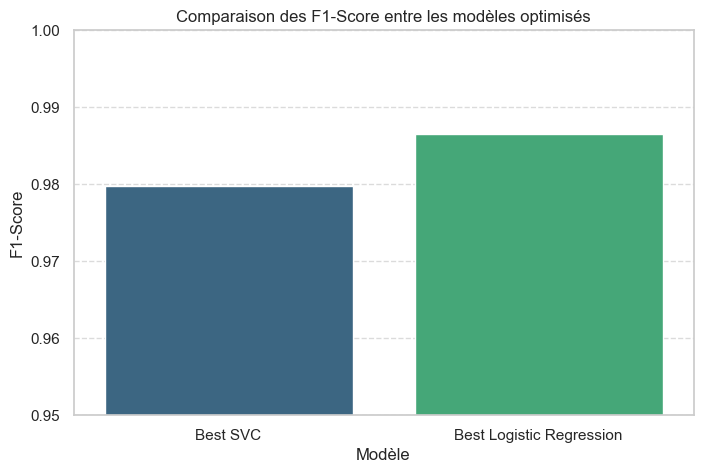

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Conversion des résultats comparatifs en DataFrame
perf_df = pd.DataFrame(compar_perf).T.reset_index()
perf_df.rename(columns={'index': 'Modèle'}, inplace=True)

#  Barplot comparatif des F1-Scores
plt.figure(figsize=(8, 5))
sns.barplot(data=perf_df, x='Modèle', y='F1-Score', palette='viridis')
plt.title("Comparaison des F1-Score entre les modèles optimisés")
plt.xlabel("Modèle")
plt.ylabel("F1-Score")
plt.ylim(0.95, 1.00)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Le graphique montre qu’il y a une petite différence de performance entre les deux modèles optimisés.

Le modèle Best SVC obtient un F1-Score d’environ 0,98, ce qui indique une très bonne capacité à bien classer les données.
Le modèle Best Logistic Regression fait un peu mieux, avec un F1-Score de 0,986, ce qui montre qu’il est légèrement plus précis et équilibré que le SVC.

Matrice de confusion du meilleur modèle

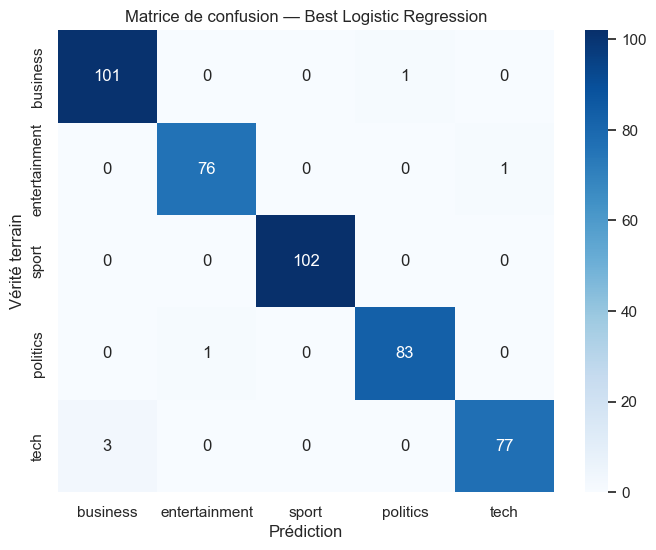

In [33]:
# Détermination automatique du meilleur modèle selon F1-Score
best_model_name = perf_df.loc[perf_df["F1-Score"].idxmax(), "Modèle"]
best_model = best_models[best_model_name]

# Prédictions du meilleur modèle optimisé
y_pred = best_model.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=y_test.unique(), 
    yticklabels=y_test.unique()
)
plt.title(f"Matrice de confusion — {best_model_name}")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

La matrice de confusion du modèle Best Logistic Regression montre que le modèle fonctionne très bien.

La plupart des échantillons sont bien classés, ce qu’on voit sur la diagonale principale (en bleu foncé).
Les classes sport, entertainment et politics sont presque parfaitement prédites.
Il y a juste quelques petites erreurs :
		- Quelques articles de la classe tech ont été classés comme business (3 cas).
		- Une seule confusion entre politics et entertainment (1 cas).

Dans l’ensemble, le modèle montre une excellente précision et très peu d’erreurs

Sauvegarde du meilleur modèle

In [34]:
import joblib

# Sauvegarde du pipeline complet : vectorisation + modèle final
best_model_name = "Logistic Regression"
joblib.dump(best_model, "best_model_bbc.joblib")

print(f" Modèle final sauvegardé avec succès : {best_model_name}")

 Modèle final sauvegardé avec succès : Logistic Regression


conclusion

Le modèle Régression Logistique a été choisi comme modèle final de ce projet.
Après l’optimisation des hyperparamètres, il a obtenu les meilleures performances globales avec une accuracy de 0.986 et un F1‑Score de 0.986, légèrement supérieures à celles du modèle SVC.

Ce choix repose sur plusieurs points clés :

Performance : c’est le modèle le plus précis sur les données de test.

Stabilité : ses résultats sont constants et équilibrés sur toutes les catégories.

Interprétabilité : son caractère linéaire permet d’identifier facilement les mots les plus représentatifs de chaque classe.

Efficacité : il s’entraîne rapidement tout en offrant une excellente capacité de généralisation.

et donc, la Régression Logistique optimisée offre le meilleur compromis entre précision, robustesse et clarté d’interprétation, ce qui justifie son choix comme modèle final du projet.

